# About Jupyter Notebook
For some of you, this might be your first time using a Jupyter notebook. Here are a few tips to get you started!

A Jupyter notebook is a file with the .ipynb extension, just like this one. It's made up of *cells*, which can be:
- Code cells - where you write your code
- Markdown cells - where you write formatted text (like this section!)

Code cell are labeled with `[ ]` on the left. When a cell is running, the label changes to `[*]`. The number inside the brackets shows the order in which cells have been executed by the *kernel*.

So, what is the kernel? The kernel is the computational 'engine' that runs the code. This notebook is connected to a Python kernel.

### Useful Keyboard Shortcuts
Jupyter notebooks offer helpful keyboard shortcuts that may save your time. First, make sure you are in *command mode* (not editing a cell). Press <kbd>Esc</kbd> or click outside the cell to exit *edit mode*.

Here are some handy shortcuts:
- Insert a new cell above or below → press <kbd>A</kbd> or <kbd>B</kbd>
- Delete a cell → press <kbd>D</kbd> twice (Note: Deleted cells cannot be recovered!)
- Restart the kernel and run all cells → press <kbd>0</kbd> twice (this is a zero!)
- Run the selected cell → press <kbd>Ctrl</kbd> + <kbd>Enter</kbd>
- Run the selected cell and move to the next cell → press <kbd>Shift</kbd> + <kbd>Enter</kbd>

Please check out the toolbar and menu bar at the top of the notebook for more options.

# Awkward Arrays
This lab uses a library called **Awkward Array**. Like Numpy, Awkward Arrays can have multiple dimensions. However, unlike Numpy, Awkward arrays support dimensions with *varying lengths*, making them ideal for handling irregular or nested data in particle physics experiments.
### Structured Data in Awkward Arrays
This lab uses structured data, where each element is a *record* with named fields (similar to a dictionary). For example:
```
array1 = ak.Array([{
    'a': [1, 2, 3],
    'b': 4,
    'c': [5, 6]
}])
```
This array `array1` contains *one* record with three fields: `'a'`, `'b'`, and `'c'`. You can access the list of fields with `array1.fields`.
### Concatenating Awkward Arrays
To combine two Awkward arrays with matching structure, use `ak.concatenate()`. An example:
```
array2 = ak.Array([{
    'a': [7, 8],
    'b': 9,
    'c': [10, 11, 12]
}])

ak.concatenate([array1, array2])
```
This results in a single Awkward Array with *two* records:
```
[
    {'a': [1, 2, 3], 'b': 4, 'c': [5, 6]},
    {'a': [7, 8],    'b': 9, 'c': [10, 11, 12]}
]
```
For more information about Awkward Arrays: https://awkward-array.org/doc/main/

# The Experiment
This experiment uses custom modules in the *backend* folder, which have been specifically developed for this third-year lab. This notebook works with **pre-processed data** derived from the **13 TeV 2025 ATLAS Open Data**.

Please run the cell below to install the required packages. You will need to do this **each time you start the server**.

In [1]:
!pip install atlasopenmagic
!pip install pyarrow==20.0.0
 
from atlasopenmagic import install_from_environment
install_from_environment(environment_file="../backend/environment.yml")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [atlasopenmagic]m [requests]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.9/30.9 MB 14.2 MB/s  0:00:02m0:00:0100:01
Installing packages: ['aiohttp>=3.9.5', 'atlasopenmagic>=1.2.0', 'awkward>=2.8.5', 'awkward-pandas>=2023.8.0', 'fsspec>=2025.7.0', 'hist>=2.8.0', 'ipykernel>=6.29.5', 'jupyter>=1.0.0', 'lmfit>=1.3.2', 'matplotlib>=3.9.1', 'metakernel>=0.30.2', 'notebook>=7', 'numpy>=1.26.4', 'pandas>=2.2.2', 'papermill>=2.6.0', 'pip>=24.2', 'scikit-learn>=1.5.1', 'uproot>=5.3.10', 'uproot3>=3.14.4', 'fsspec-xrootd>=0.5.1', 'jupyterlab_latex>=3.1.0', 'vector>=1.4.1']
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.7/913.7 kB 5.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.9/542.9 kB 14.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 998.8/998.8 kB 20.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 16.2 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 20.9

The above cell is likely to take about 30 seconds to run.  Wait until the [*] to the left of the above cell becomes a number, indicating that it has finished running.  Then, run the cell below to import the required modules and functions for the experiment. Repeat this step **every time you restart the kernel**.

In [2]:
import os
import re
import awkward as ak
import time
import datetime
from zoneinfo import ZoneInfo
import uproot
import glob
import numpy as np
import vector
import hist
from hist import Hist
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import pyarrow.parquet as pq
import sys
sys.path.append('../')
from backend import get_valid_variables, validate_read_variables
from backend import plot_stacked_hist, plot_histograms, histogram_2d, plot_errorbars
from backend import get_histogram, analysis_parquet, VALID_STR_CODE, produced_event_count

Fetching metadata for release: 2025e-13tev-beta...
Fetching datasets: 100%|██████████| 374/374 [00:00<00:00, 1035.45datasets/s]
✓ Successfully cached 374 datasets.
Active release: 2025e-13tev-beta. (Datasets path: REMOTE)


In [ ]:
# debug settings:
'''
import awkward as ak
import uproot
import pyarrow
import hist
import vector
import matplotlib.pyplot as plt
import atlasopenmagic
print("imports ok")
'''



imports ok


## Accessing Data Samples
Data samples stored in the folder *backend/parquet* can be accessed using a *string code*. The available string codes are listed below:  
#### Available Final-State Collections (Real Data)
* `'2to4lep'` - Events with two to four leptons, each with at least 7 GeV of transverse momentum $p_T$
* `'GamGam'` - Events with at least two photons, each with at least 25 GeV of $p_T$

#### Available Monte Carlo Simulation Datasets include
* `'Zee'` - Simulated $Z \rightarrow e^+e^-$ events
* `'Zmumu'` - Simulated $Z \rightarrow \mu^+\mu^-$ events
* `'Ztautau'` - Simulated $Z \rightarrow \tau^+\tau^-$ events
* `'ttbar'` - Simulated $t\overline{t}$ events
* `'Hyy'` - Simulated $H \rightarrow \gamma \gamma$ events

You can use the function `VALID_STR_CODE` to view all available string codes.

In [3]:
VALID_STR_CODE

['2to4lep',
 'Zee',
 'Zmumu',
 'Ztautau',
 'VBF_Zee',
 'VBF_Zmumu',
 'VBF_Ztautau',
 'Zee_BFil',
 'Zee_CFilBVeto',
 'Zee_CVetoBVeto',
 'Zmumu_BFil',
 'Zmumu_CFilBVeto',
 'Zmumu_CVetoBVeto',
 'Wenu',
 'Wmunu',
 'Wtaunu',
 'VBF_Wenu',
 'VBF_Wmunu',
 'VBF_Wtaunu',
 'ttbar',
 'VV4l',
 'm10_40_Zee',
 'm10_40_Zmumu',
 'ggH_H4l',
 'VBF_H4l',
 'WpH_H4l',
 'WmH_H4l',
 'ZH_H4l',
 'ggZH_H4l',
 'ttH_H4l',
 'GamGam',
 'ggF_Hyy',
 'VBF_Hyy',
 'WpH_Hyy',
 'WmH_Hyy',
 'ZH_Hyy',
 'ggZH_Hyy',
 'ttH_Hyy',
 'VBF_Zll',
 'm10_40_Zll',
 'Wlepnu',
 'VBF_Wlepnu',
 'H4l',
 'Hyy']

To combine multiple datasets, combine the string codes using `'+'`. For example, if you would like to combine the $Z \rightarrow \mu^+\mu^-$ and $Z \rightarrow e^+e^-$ datasets, use the string code `'Zee+Zmumu'`.

The sample files in the folder *backend/parquet* contain records, each of which corresponds to an individual LHC *event*. The record for each *event* contains information about the leptons and/or photons found in that event. You can view the available variables using the `get_valid_variables` function that is defined in the folder *backend*. An example is shown in the code cell below.

In [4]:
string_code = '2to4lep'
get_valid_variables(string_code)

Variables validated using ../../parquet/2to4lep/chunk_0.parquet


['lep_n',
 'lep_pt',
 'lep_eta',
 'lep_phi',
 'lep_e',
 'lep_ptvarcone30',
 'lep_topoetcone20',
 'lep_type',
 'lep_charge',
 'lep_isLooseID',
 'lep_isMediumID',
 'lep_isTightID',
 'lep_isLooseIso',
 'lep_isTightIso',
 'trigE',
 'trigM',
 'lep_isTrigMatched',
 'totalWeight']

The function `analysis_parquet` reads datasets specified by the `string_code_list` input and returns a dictionary containing the selected data. By default the selected data is stored in memory for subsequent histogramming/fitting. The parameter `fraction` determines the fraction of each dataset to load; the default value is `1`. For di-lepton analysis, it is recommended to start with `fraction = 0.01` or lower to reduce memory usage.

In [5]:
string_code_list = ['2to4lep', 'Zee'] # List of dataset codes to load
read_variables = ['lep_n', 'lep_pt']
fraction = 0.01 # Fraction of each dataset to load
# Call analysis_parquet to read the datasets and return the data as a dictionary
data = analysis_parquet(read_variables, string_code_list, fraction=fraction)
data

Input string_code_list found. Data samples will be accessed by the string code(s).
Elapsed time = 2.3s


{'2to4lep_0_01': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='724561 * {lep_n: int32, ...'>,
 'Zee_0_01': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='450511 * {lep_n: int32, ...'>}

As shown in the example above, the `analysis_parquet` function returns a dictionary where:
- **Keys** are constructed by combining each dataset code from `string_code_list` with the `fraction` (e.g. for `2to4lep` and `fraction = 0.01`, the key is `'2to4lep_0_01`)
- **Values** are Awkward Arrays, where each entry corresponds to an event represented as a record (similar to a Python dictionary). The fields in each record correspond to the variables listed in `read_variables`.

For example, the dictionary returned by the `analysis_parquet` may look like this:
```
data = {
    '2to4lep_0_01': Array([
        {'lep_n': 2, 'lep_pt': [106, 47.6]},
        {'lep_n': 2, 'lep_pt': [41.6, 37.3]},
    ]),
    'Zee_0_01': Array([
        ...
    ])
}
```

Let's interpret the first event in the `'2to4lep_0_01'` dataset, which is represented by the first record in the Awkward Array stored under the `'2to4lep_0_01'` key (i.e., `data['2to4lep_0_01']`).
- The number of leptons in this event is 2 (`lep_n : 2`)
- The field `lep_pt` lists their transverse momenta: The first lepton has $p_T = 106$ GeV, and the second lepton has $p_T = 47.6$ GeV.

To extract the $p_T$ of the first lepton from all events in the `'2to4lep_0_01'` dataset, use  
`data['2to4lep_0_01']['lep_pt'][:, 0]`.

In [6]:
data['2to4lep_0_01']['lep_pt'][:, 0] # pT of the first lepton from all events

<Array [39.4, 45.2, 44.3, 59, ..., 10.3, 47.8, 35.4] type='724561 * float32'>

## Event Weights
For a variety of reasons each event in the MC data has an associated *weight*.  

When an event from the ATLAS experiment data is added to one of your histograms then the relevant histogram bin is incremented by 1.0.  However, when using MC events the relevant histogram bin is incremented by an amount `'totalWeight'`.  

You have access to 36 fb$^{-1}$ of real ATLAS data.  However, the MC samples for most of the physical processes have a larger number of events than would be expected in 36 fb$^{-1}$ of data.  The application of a weight (typically less than one) ensures that the total number of events you see in MC histograms is equal to that predicted for the equivalent ATLAS data set.  This calculation involves knowing the predicted cross section, $\sigma$, for each considered physical process and the integrated luminosity, $\int\mathcal{L} dt$.  The *weight* also corrects for discrepancies in experimental efficiencies between the MC simulation and the real ATLAS detector.

You don't need to explicitly include `'totalWeight'` in `read_variables`. If the field is present in the data (i.e. in MC samples), `analysis_parquet` will return it automatically.

Take a look the `EventWeights` module in the backend folder if you're curious how the variable is calculated!

**_Tip_**: Please be careful not to edit any of the code in the backend folder – unless you really know what you are doing you could cause the code to perform in unexpected ways!

## Event Selection

You can also perform event selection by defining a custom *cut function*, which can be passed to `analysis_parquet` via the argument `cut_function`. This function takes the full dataset as input and returns a filtered version according to your selection criteria. In addition, you can compute new variables within the cut function and store them in memory as new fields in the event records. 

The example below selects events with exactly two final-state leptons. It then computes the invariant mass by summing their four-momentum vectors and accessing the `.M` attribute as implemented in the `dilep_cut` function. This function is passed to the `analysis_parquet` via the `cut_function` argument.

In [7]:
#string_code_list = ['2to4lep'] # List of dataset codes to load
string_code_list = ['2to4lep', 'Zmumu', 'm10_40_Zmumu', 'Ztautau', 'ttbar', 'Wmunu'] # List of dataset codes to load

# Variables to read from the dataset
read_variables = ['lep_pt', 'lep_eta', 'lep_phi', 'lep_e', 'lep_type', 'lep_charge', 'lep_n', 'trigM', 'trigE']
# , 'lep_isLooseID', 'lep_isMediumID', 'lep_isLooseIso', 'lep_isTightIso', 'lep_isTrigMatched']   # other variables that could be read in

# You may also use the pre-defined function `validate_read_variables` to validate your `read_variables`. 
read_variables = validate_read_variables(string_code_list, read_variables)

# Custom selection cut function to filter the data
def pt_cut(data):
    # Cut on lepton number - Only keep events that have two leptons
    data = data[data['lep_n'] == 2] 

    # Cut on lep_type
    # lep_type is 11 for electron, 13 for muon
    data = data[data['lep_type'][:, 0] + data['lep_type'][:, 1] == 26] # Keep events with two muons

    # Cuts on lepton pt
    # Use bitwise operator '&' for AND, '|' for OR. Remember the parentheses!
    data = data[(data['lep_pt'][:, 0] > 10) & (data['lep_pt'][:, 1] > 10)]   # Keep events where both leptons have pt > 10 GeV

    # Require that a single muon trigger fired 
    data = data[(data['trigM'])] 

    # Define four momentum
    four_momentum = vector.zip({
        'pt': data['lep_pt'],
        'eta' : data['lep_eta'],
        'phi' : data['lep_phi'],
        'E' : data['lep_e']
    })
    # Add the 4-momentum of the two leptons in each event and get the 
    # invariant mass using .M
    data['mass'] = (four_momentum[:, 0] + four_momentum[:, 1]).M
    
    # Cut on di-lepton mass
    cut_low = 0
    cut_high = 1000   
    cut_mass = (data['mass']>cut_low) &  (data['mass']<cut_high)
    data = data[cut_mass] # Select events satisfying the condition: cut_low < mass < cut_high (GeV)
 
    return data

fraction = 0.02
pt_data = analysis_parquet(read_variables, string_code_list, fraction=fraction, cut_function=pt_cut)
pt_data

Variables validated using ../../parquet/2to4lep/chunk_0.parquet
Variables validated using ../../parquet/Zmumu/chunk_0.parquet
Variables validated using ../../parquet/m10_40_Zmumu/chunk_0.parquet
Variables validated using ../../parquet/Ztautau/chunk_0.parquet
Variables validated using ../../parquet/ttbar/chunk_0.parquet
Variables validated using ../../parquet/Wmunu/chunk_0.parquet
Input string_code_list found. Data samples will be accessed by the string code(s).
Elapsed time = 3.5s


{'2to4lep_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='573455 * {lep_n: int32, ...'>,
 'Zmumu_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='877353 * {lep_n: int32, ...'>,
 'm10_40_Zmumu_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='27714 * {lep_n: int32, l...'>,
 'Ztautau_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='3176 * {lep_n: int32, le...'>,
 'ttbar_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='8264 * {lep_n: int32, le...'>,
 'Wmunu_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='2183 * {lep_n: int32, le...'>}

If you only need data for a specific lepton — for example, the $p_T$ of the first lepton — you can include `'lepton_pt[0]'` in `read_variables` instead of `'lepton_pt'`. This saves memory by storing the data as a flat array rather than a nested one. However, do this only if `'lepton_pt'` is not required elsewhere, such as in the cut function.

## Plot Stacked Histogram
The dictionary returned by `analysis_parquet` can be used to plot a stacked histogram by passing it to the `plot_stacked_hist` function.

To use this function correctly, there are a few points to take note of:
- The first argument must be a **dictionary**.
- If a dictionary key includes `'Data'`, its content will be plotted as data points with error bars.
- If a dictionary key includes `'Signal'`, its content will be stacked as histogram bars on top of the background.
- Python strings are case-sensitive, i.e. `'Data'` and `'data'` are treated differently!

An example is shown below, where `'2to4lep_0_01'` is treated as data and `'Zee_0_01'` as the signal.

Elapsed time = 0.5s


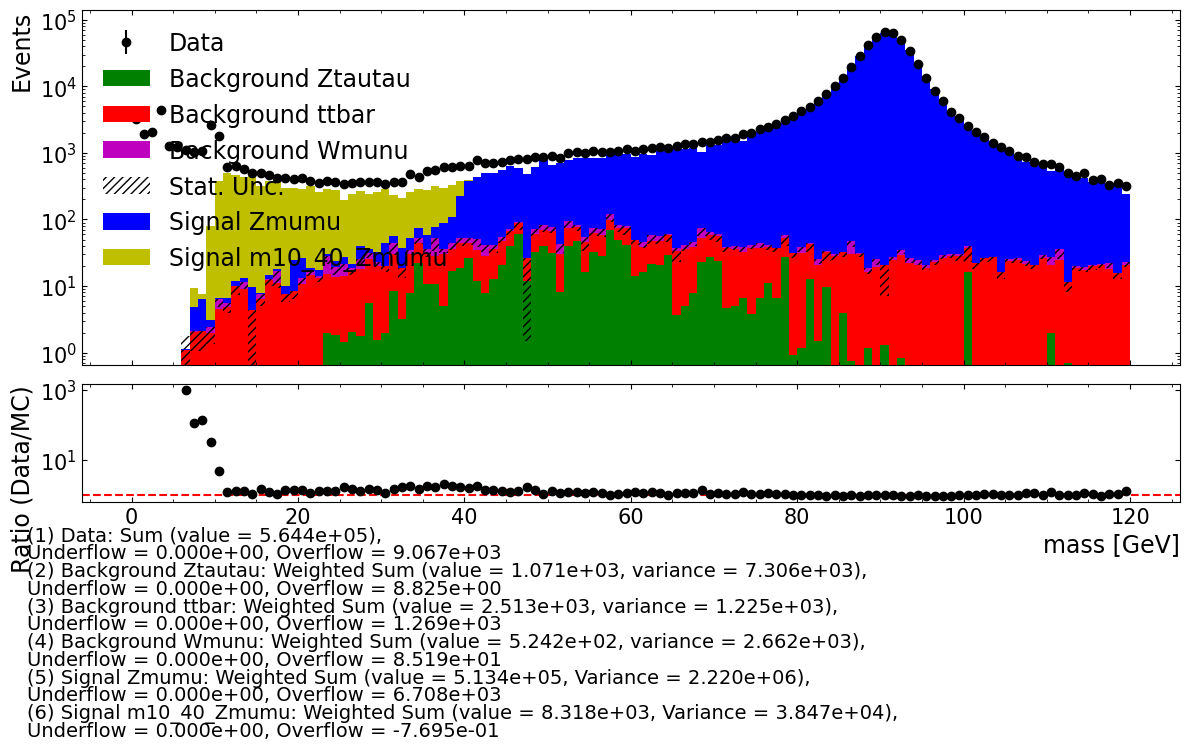

In [8]:
# Define what to plot: '2to4lep_0_01' as data, 'Zee_0_01' as signal
plot_dict = {
    'Data' : pt_data['2to4lep_0_02'],
    'Signal Zmumu' : pt_data['Zmumu_0_02'], 
    'Signal m10_40_Zmumu' : pt_data['m10_40_Zmumu_0_02'], 
    'Background Ztautau': pt_data['Ztautau_0_02'],
    'Background ttbar' : pt_data['ttbar_0_02'], 
    'Background Wmunu' : pt_data['Wmunu_0_02'],
}

# Define plot appearance
#color_list = ['k'] # Black (data)
color_list = ['k', 'b', 'y', 'g', 'r', 'm'] # Black (data), blue (signal), yellow (signal), green (Ztautau), red (ttbar), magenta (Wmunu')

# Variable to plot on the x-axis
plot_variable = 'mass'

xmin, xmax = 0, 120 # Define histogram bin range and x-axis limits 
num_bins = 120 # Number of histogram bins
x_label = 'mass [GeV]' # x-axis label 

# Plot the histogram
fig, hists = plot_stacked_hist(plot_dict, plot_variable, color_list,
                               num_bins, xmin, xmax, x_label, logy=True, show_text=True, residual_plot=True, save_fig=False)

The `plot_stacked_hist` function accepts several optional parameters that allow you to customise the appearance and behaviour of the plot:
- `y_label` : Label for the y-axis
- `ylim` : Tuple of two numbers for y-axis limits
- `logy` : Set to `True` to use a logarithmic y-axis
- `title` : Title of the plot
- `marker` : Marker style for the data points (default: `'o'`)
- `fig_size` : Tuple of two numbers for the figure size (default: `(12, 8)`)
- `show_text` : Set to `True` to display text annotations (histogram information) on the plot
- `show_back_unc` : Set to `False` to hide background uncertainty
- `save_fig` : Set to `True` to save the figure
- `fig_name` : String filename to save the plot as an image
- `residual_plot` : Set to `True` to add a residual plot (Data / MC) below the main plot
- `residual_plot_ylim` : Tuple of two numbers for residual plot y-axis limits
- `title_fontsize` : Font size for the plot title (default: 17)
- `label_fontsize` : Font size for the x and y axis labels (default: 17)
- `legend_fontsize` : Font size for the legend (default: 17)
- `tick_labelsize` : Font size for the axis tick labels  (default: 15)
- `text_fontsize` : Font size for text annotations (default: 14)

The function returns a `Figure` object and a **list** of `Hist` objects corresponding to each dataset. 

## Hist
`Hist` objects can be used to inspect the histogram contents, including the bin values, variances (for MC datasets), and underflow/overflow bins.  
The second value returned by `plot_stacked_hist` is a list of `Hist` objects. They are in the order 'Data', 'Background', 'Signal'.

Here are some useful methods:
- `.sum()` - total sum of all bin contents
- `.view()` - bin values (Data)
- `.view().value` - bin values (MC)
- `.view().variance` - bin variances (MC)
- `.view(flow=True)[0]` - underflow bin value
- `.view(flow=True)[-1]` - overflow bin value
- `.axes[0].centers` - bin centres
  
For example, try uncommenting the lines below to explore the contents of a `Hist` object:

In [ ]:
# In our example, the first Hist object (index 0) is Data, and the second (index 1) is MC
hists                 # View the full histogram object
#hists[2]                 # View the full histogram object
# hists[0].sum()         # Total sum of all bin contents
# hists[0].view()        # Access the bin values (excluding flow bins)

[Hist(Regular(120, 0, 120, name='Data'), storage=Double()) # Sum: 564388.0 (573455.0 with flow),
 Hist(Regular(120, 0, 120, name='Background Ztautau'), storage=Weight()) # Sum: WeightedSum(value=1070.58, variance=7306.25) (WeightedSum(value=1079.41, variance=7323.01) with flow),
 Hist(Regular(120, 0, 120, name='Background ttbar'), storage=Weight()) # Sum: WeightedSum(value=2512.94, variance=1224.68) (WeightedSum(value=3782.38, variance=1839.87) with flow),
 Hist(Regular(120, 0, 120, name='Background Wmunu'), storage=Weight()) # Sum: WeightedSum(value=524.241, variance=2661.83) (WeightedSum(value=609.436, variance=2955.24) with flow),
 Hist(Regular(120, 0, 120, name='Signal Zmumu'), storage=Weight()) # Sum: WeightedSum(value=513388, variance=2.21957e+06) (WeightedSum(value=520096, variance=2.2464e+06) with flow),
 Hist(Regular(120, 0, 120, name='Signal m10_40_Zmumu'), storage=Weight()) # Sum: WeightedSum(value=8317.87, variance=38473.2) (WeightedSum(value=8317.1, variance=38477.8) with 

For more information about `Hist`, see https://hist.readthedocs.io/en/latest/.

For more information about `matplotlib.pyplot`, see https://matplotlib.org/stable/api/pyplot_summary.html.

The function `savefig` saves a copy of the figure you have just produced.
    Note an alternative is to set the input argument `save_fig` to `True` in the function `plot_stacked_hist`.

In [ ]:
fig.savefig(plot_variable+'.png')

## Additional Plotting Functions
If you want to plot additional variables to identify where the selection cut could be tightened, the `plot_histograms` function is for you. This function returns:
- A **list** of `Figure` objects (one per variable plotted)
- A corresponding **list of lists** of `Hist` objects

There are some arguments worth pointing out:
- `xmin_xmax_list` : a tuple of two numbers applied to all plots, or a list of tuples (one per variable)
- `num_bins_list` : an int applied to all plots, or a list of int (one per variable)

The same applies to these optional arguments: `y_label_list`, `ylim_list`, `title_list`, and `residual_ylim_list`. These can be specified as a single value applied to all plots or as a list matching the number of variables.

Elapsed time = 0.2s


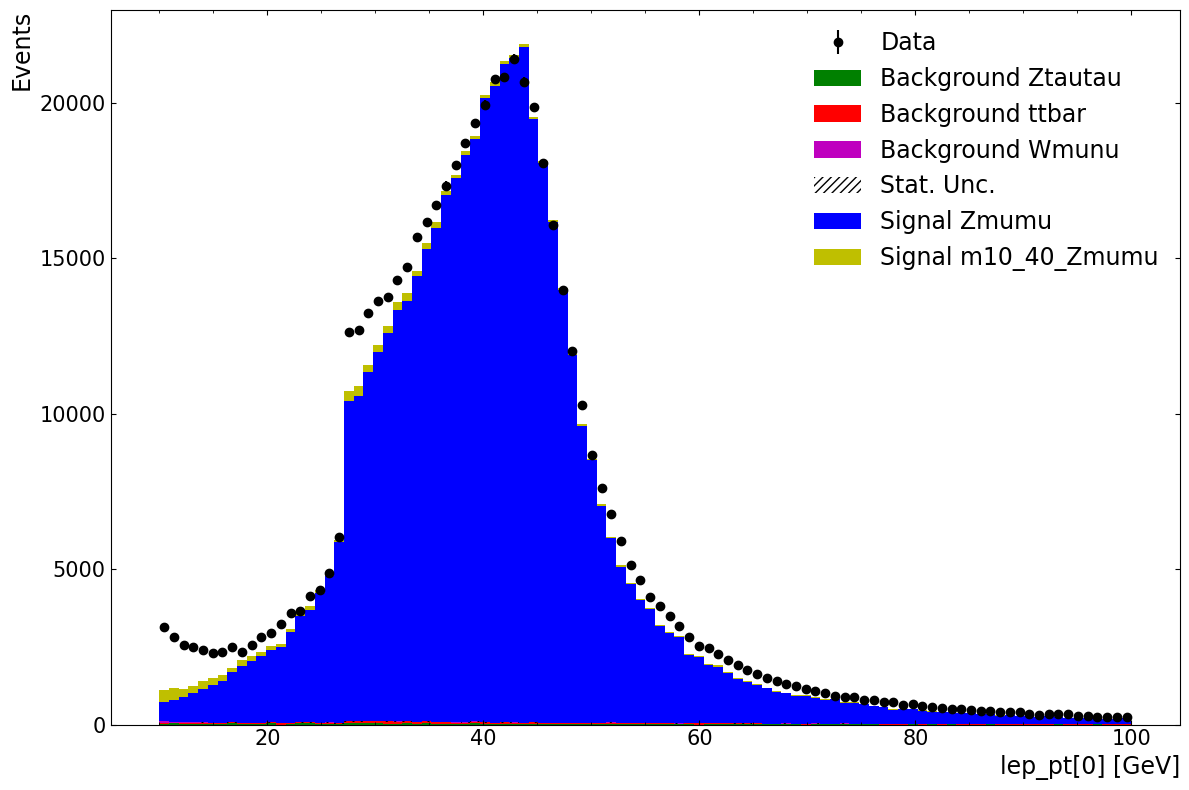

Elapsed time = 0.7s


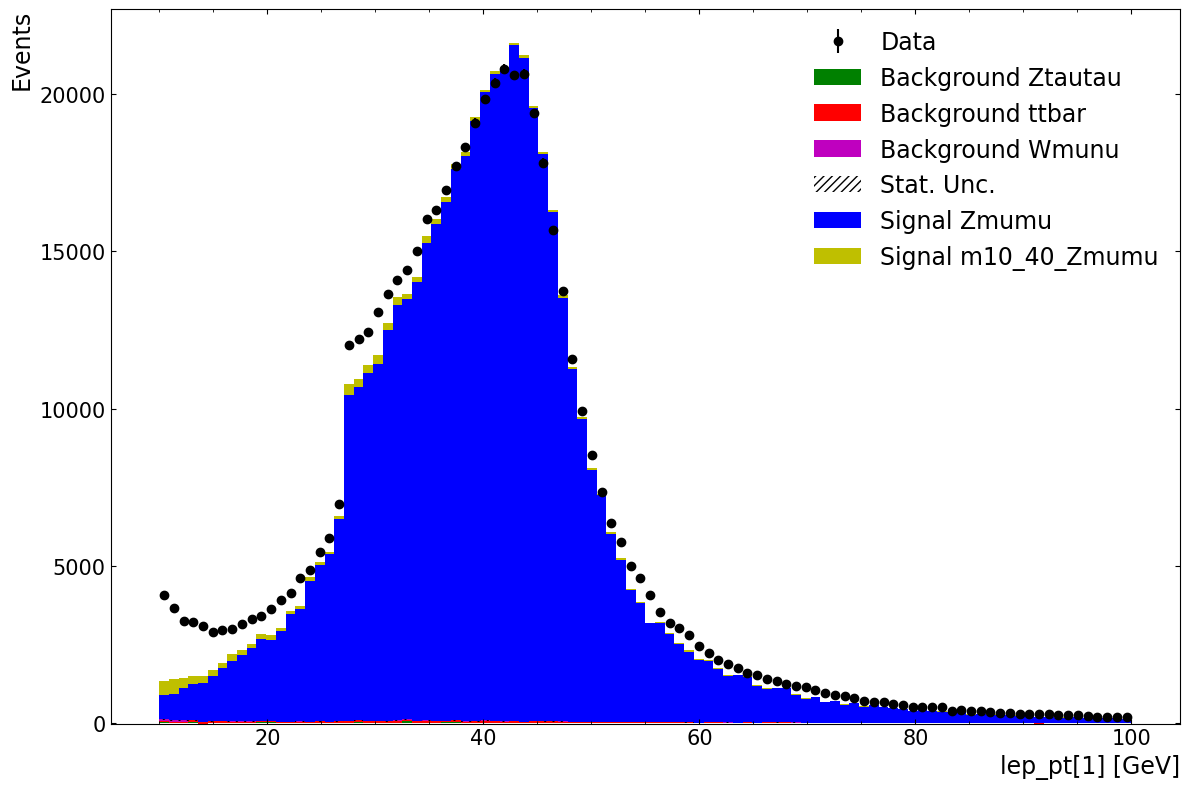

Elapsed time = 1.0s


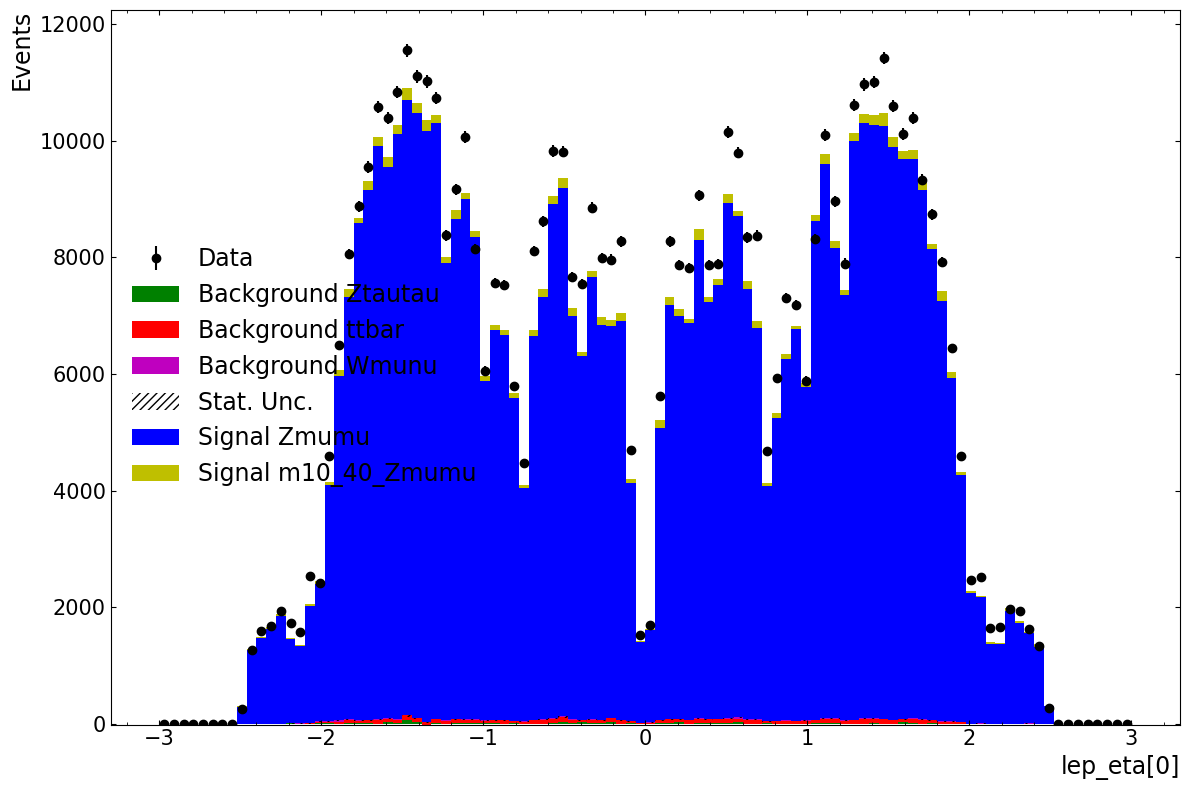

Elapsed time = 1.5s


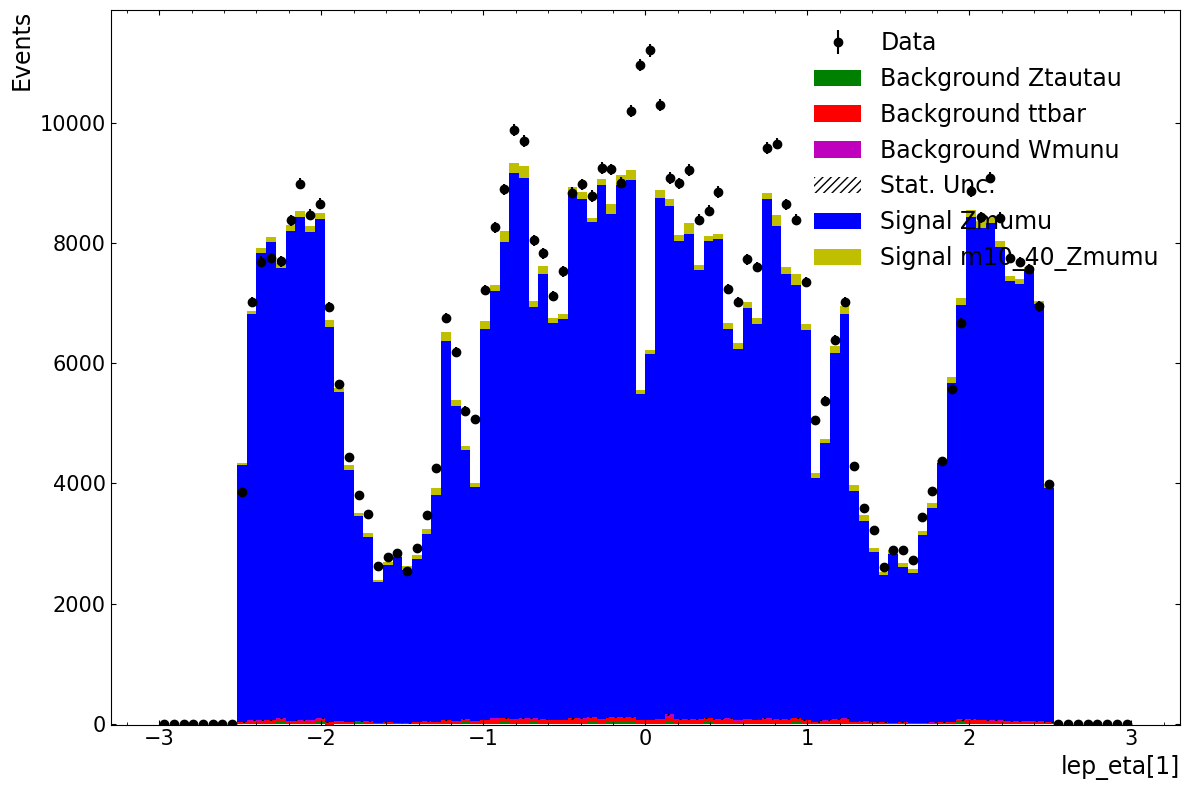

([<Figure size 1200x800 with 1 Axes>,
  <Figure size 1200x800 with 1 Axes>,
  <Figure size 1200x800 with 1 Axes>,
  <Figure size 1200x800 with 1 Axes>],
 [[Hist(Regular(100, 10, 100, name='Data'), storage=Double()) # Sum: 566545.0 (573455.0 with flow),
   Hist(Regular(100, 10, 100, name='Background Ztautau'), storage=Weight()) # Sum: WeightedSum(value=1069.6, variance=7312.92) (WeightedSum(value=1079.41, variance=7323.01) with flow),
   Hist(Regular(100, 10, 100, name='Background ttbar'), storage=Weight()) # Sum: WeightedSum(value=3379.59, variance=1645.39) (WeightedSum(value=3782.38, variance=1839.87) with flow),
   Hist(Regular(100, 10, 100, name='Background Wmunu'), storage=Weight()) # Sum: WeightedSum(value=595.072, variance=2944.39) (WeightedSum(value=609.436, variance=2955.24) with flow),
   Hist(Regular(100, 10, 100, name='Signal Zmumu'), storage=Weight()) # Sum: WeightedSum(value=515514, variance=2.2432e+06) (WeightedSum(value=520096, variance=2.2464e+06) with flow),
   Hist(Re

In [ ]:
# Plot many variables at once 
plot_dict = {
    'Data' : pt_data['2to4lep_0_02'],
    'Signal Zmumu' : pt_data['Zmumu_0_02'], 
    'Signal m10_40_Zmumu' : pt_data['m10_40_Zmumu_0_02'], 
    'Background Ztautau': pt_data['Ztautau_0_02'],
    'Background ttbar' : pt_data['ttbar_0_02'], 
    'Background Wmunu' : pt_data['Wmunu_0_02'],
}

# Define plot appearance
#color_list = ['k'] # Black (data)
color_list = ['k', 'b', 'y', 'g', 'r', 'm'] # Black (data), blue (signal), yellow (signal), green (Ztautau), red (ttbar), magenta (Wmunu')


plot_variables = ['lep_pt[0]', 'lep_pt[1]', 'lep_eta[0]', 'lep_eta[1]']
xmin_xmax_list = [(10, 100), (10, 100), (-3, 3), (-3, 3)] # Bin range for each variable
num_bins_list = 100
x_label_list = ['lep_pt[0] [GeV]', 'lep_pt[1] [GeV]', 'lep_eta[0]', 'lep_eta[1]']

plot_histograms(
    plot_dict,
    plot_variables,
    color_list,
    xmin_xmax_list, # If you provide a tuple of 2 numbers, that will be applied to all plots
    num_bins_list,
    x_label_list,
    # Optional arguments start from here
    # y_label_list=None, # Str or list of str for y-axis label
    # ylim_list=None, # Tuple of 2 numbers or list of tuples for y axis limit
    logy=False, # Whether to set the y axis as log scale
    # title_list=None, # Str or list of str for title
    # marker='o', # Marker type
    # title_fontsize=17, # Fontsize for title
    # label_fontsize=17, # Fontsize for x and y axes
    # legend_fontsize=17, # Fontsize for legend
    # tick_labelsize=15, # Fontsize for x and y axes ticks
    # text_fontsize=14, # Fontsize for text that shows histogram info
    # fig_size=(12, 8), # Figure size
    # show_text=False, # Whether to show the text that displays histogram info
    # show_back_unc=True, # Whether to show the background uncertainty
    save_fig=False, # Whether to save figure
    # fig_name=None, # Filename of the image. If not provided, save figure using the plot_variable and the keys of data_dict
    residual_plot=False # Whether to show residual plot under the main plot
    # residual_ylim_list=None # Tuple of 2 numbers or list of tuples for residual plot y-axis limit
)         

The `plot_errorbars` function is designed for situations where you want to:
- Plot the same variable for different particles in the same event on a single figure, or
- Compare histograms under different selection cuts.

The first argument to `plot_errorbars` must be a dictionary. Each value in this dictionary should also be a dictionary containing the following keys:
- `'color'`: Color to be used for plotting
- `'array'`: The data array to be histogrammed
- `'weight'`: Weights associated with each data point

This function returns:
- A `Figure` object (for saving), and
- A list of `Hist` objects representing the histograms for each key

Below are some examples demonstrating how to use the `plot_errorbars` function.

Elapsed time = 0.0s


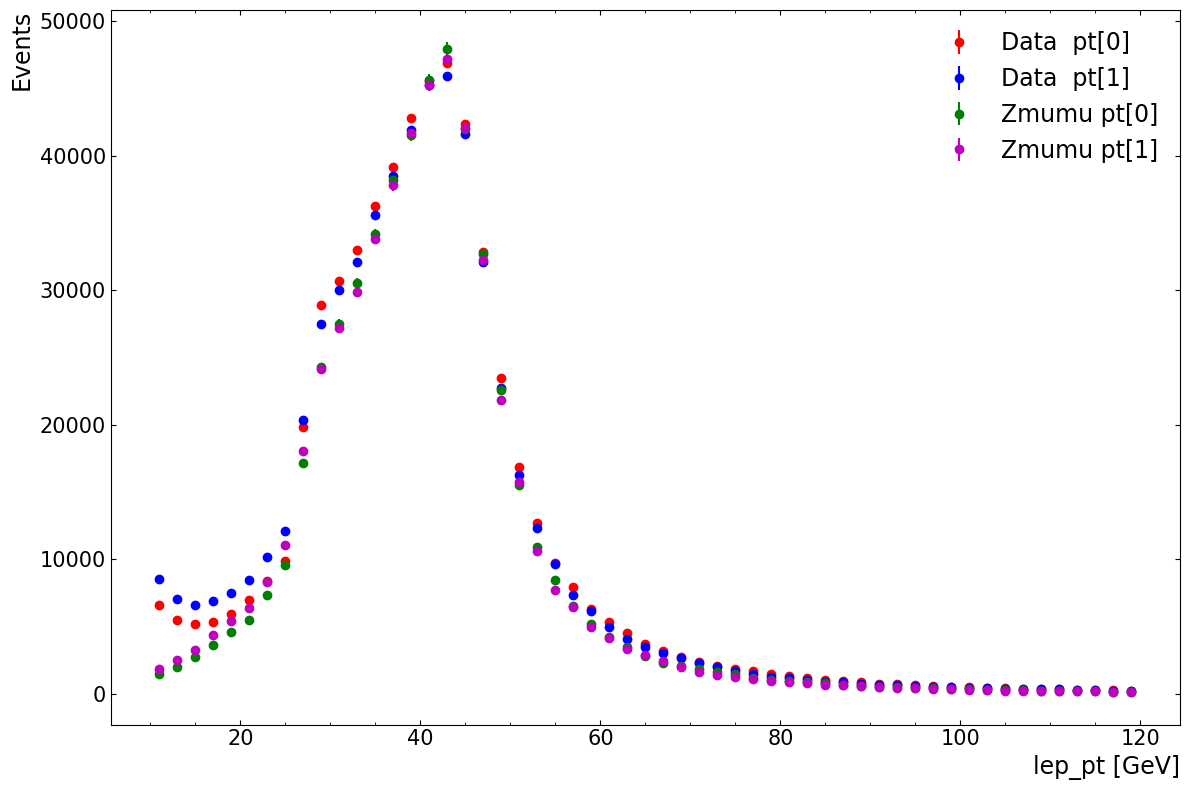

(<Figure size 1200x800 with 1 Axes>,
 [Hist(Regular(55, 10, 120, name='Data  pt[0]'), storage=Double()) # Sum: 569916.0 (573455.0 with flow),
  Hist(Regular(55, 10, 120, name='Data  pt[1]'), storage=Double()) # Sum: 570131.0 (573455.0 with flow),
  Hist(Regular(55, 10, 120, name='Zmumu pt[0]'), storage=Weight()) # Sum: WeightedSum(value=517771, variance=2.24469e+06) (WeightedSum(value=520096, variance=2.2464e+06) with flow),
  Hist(Regular(55, 10, 120, name='Zmumu pt[1]'), storage=Weight()) # Sum: WeightedSum(value=517991, variance=2.24475e+06) (WeightedSum(value=520096, variance=2.2464e+06) with flow)])

In [ ]:
# Compare pt of the two leptons
data_dict = {
    'Data  pt[0]' : {'color' : 'r',
                          'array' : pt_data['2to4lep_0_02']['lep_pt'][:, 0],
                          'weight' : None},
    'Data  pt[1]' : {'color' : 'b',
                          'array' : pt_data['2to4lep_0_02']['lep_pt'][:, 1],
                          'weight' : None},
    'Zmumu pt[0]' : {'color' : 'g',
                         'array' : pt_data['Zmumu_0_02']['lep_pt'][:, 0],
                         'weight' : pt_data['Zmumu_0_02']['totalWeight']},
    'Zmumu pt[1]' : {'color' : 'm',
                         'array' : pt_data['Zmumu_0_02']['lep_pt'][:, 1],
                         'weight' : pt_data['Zmumu_0_02']['totalWeight']},
}
xmin, xmax = 10, 120
num_bins = 55
x_label = 'lep_pt [GeV]'

plot_errorbars(data_dict,
               xmin,
               xmax,
               num_bins,
               x_label,
               # Optional arguments
               # y_label='Events',
               # logy=False,
               # title='',
               # marker='o',
               # title_fontsize=17,
               # label_fontsize=17,
               # legend_fontsize=17,
               # tick_labelsize=15,
               # text_fontsize=14,
               # show_text=False,
               # fig_size=(12, 8)
)

In [ ]:
# Create a second copy of the data in memory, having applied a different set of event selection cuts (from those applied above in function "pt_cut()"

def pt20_cut(data):
    # Cut on lepton number, type and pt
    data = data[data['lep_n'] == 2] 
    data = data[data['lep_type'][:, 0] + data['lep_type'][:, 1] == 26]
    data = data[(data['lep_pt'][:, 0] > 20) & (data['lep_pt'][:, 1] > 20)]

    # Require that a single muon trigger fired 
    data = data[(data['trigM'])] 

    four_momentum = vector.zip({
        'pt': data['lep_pt'],
        'eta' : data['lep_eta'],
        'phi' : data['lep_phi'],
        'E' : data['lep_e']
    })
    # Add the 4-momentum of the two leptons in each event and get the 
    # invariant mass using .M
    data['mass'] = (four_momentum[:, 0] + four_momentum[:, 1]).M
    
    return data

pt20_data = analysis_parquet(read_variables, string_code_list, fraction=fraction, cut_function=pt20_cut)
pt20_data

Input string_code_list found. Data samples will be accessed by the string code(s).
Elapsed time = 3.3s


{'2to4lep_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='508455 * {lep_n: int32, ...'>,
 'Zmumu_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='765189 * {lep_n: int32, ...'>,
 'm10_40_Zmumu_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='14655 * {lep_n: int32, l...'>,
 'Ztautau_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='1665 * {lep_n: int32, le...'>,
 'ttbar_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='6697 * {lep_n: int32, le...'>,
 'Wmunu_0_02': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='497 * {lep_n: int32, lep...'>}

In [ ]:
# Compare histograms under different cuts
data_dict = {
    'Data pt>20' : {'color' : 'r',
                    'array' : pt20_data['2to4lep_0_02']['mass'],
                    'weight' : None},
    'Zmumu pt>20' : {'color' : 'g',
                   'array' : pt20_data['Zmumu_0_02']['mass'],
                   'weight' : pt20_data['Zmumu_0_02']['totalWeight']},
    'Data pt>10' : {'color' : 'b',
                    'array' : pt_data['2to4lep_0_02']['mass'],
                    'weight' : None},
    'Zmumu pt>10' : {'color' : 'm',
                   'array' : pt_data['Zmumu_0_02']['mass'],
                   'weight' : pt_data['Zmumu_0_02']['totalWeight']},
}

xmin, xmax = 50, 140 # Define histogram bin range and x-axis limits 
num_bins = 90 # Number of histogram bins
x_label = 'mass [GeV]'

plot_errorbars(data_dict, xmin, xmax, num_bins, x_label, logy=True)

## 2D Histogram
If you want to plot a 2D histogram, you can use the `histogram_2d` function as shown in the code cell below.

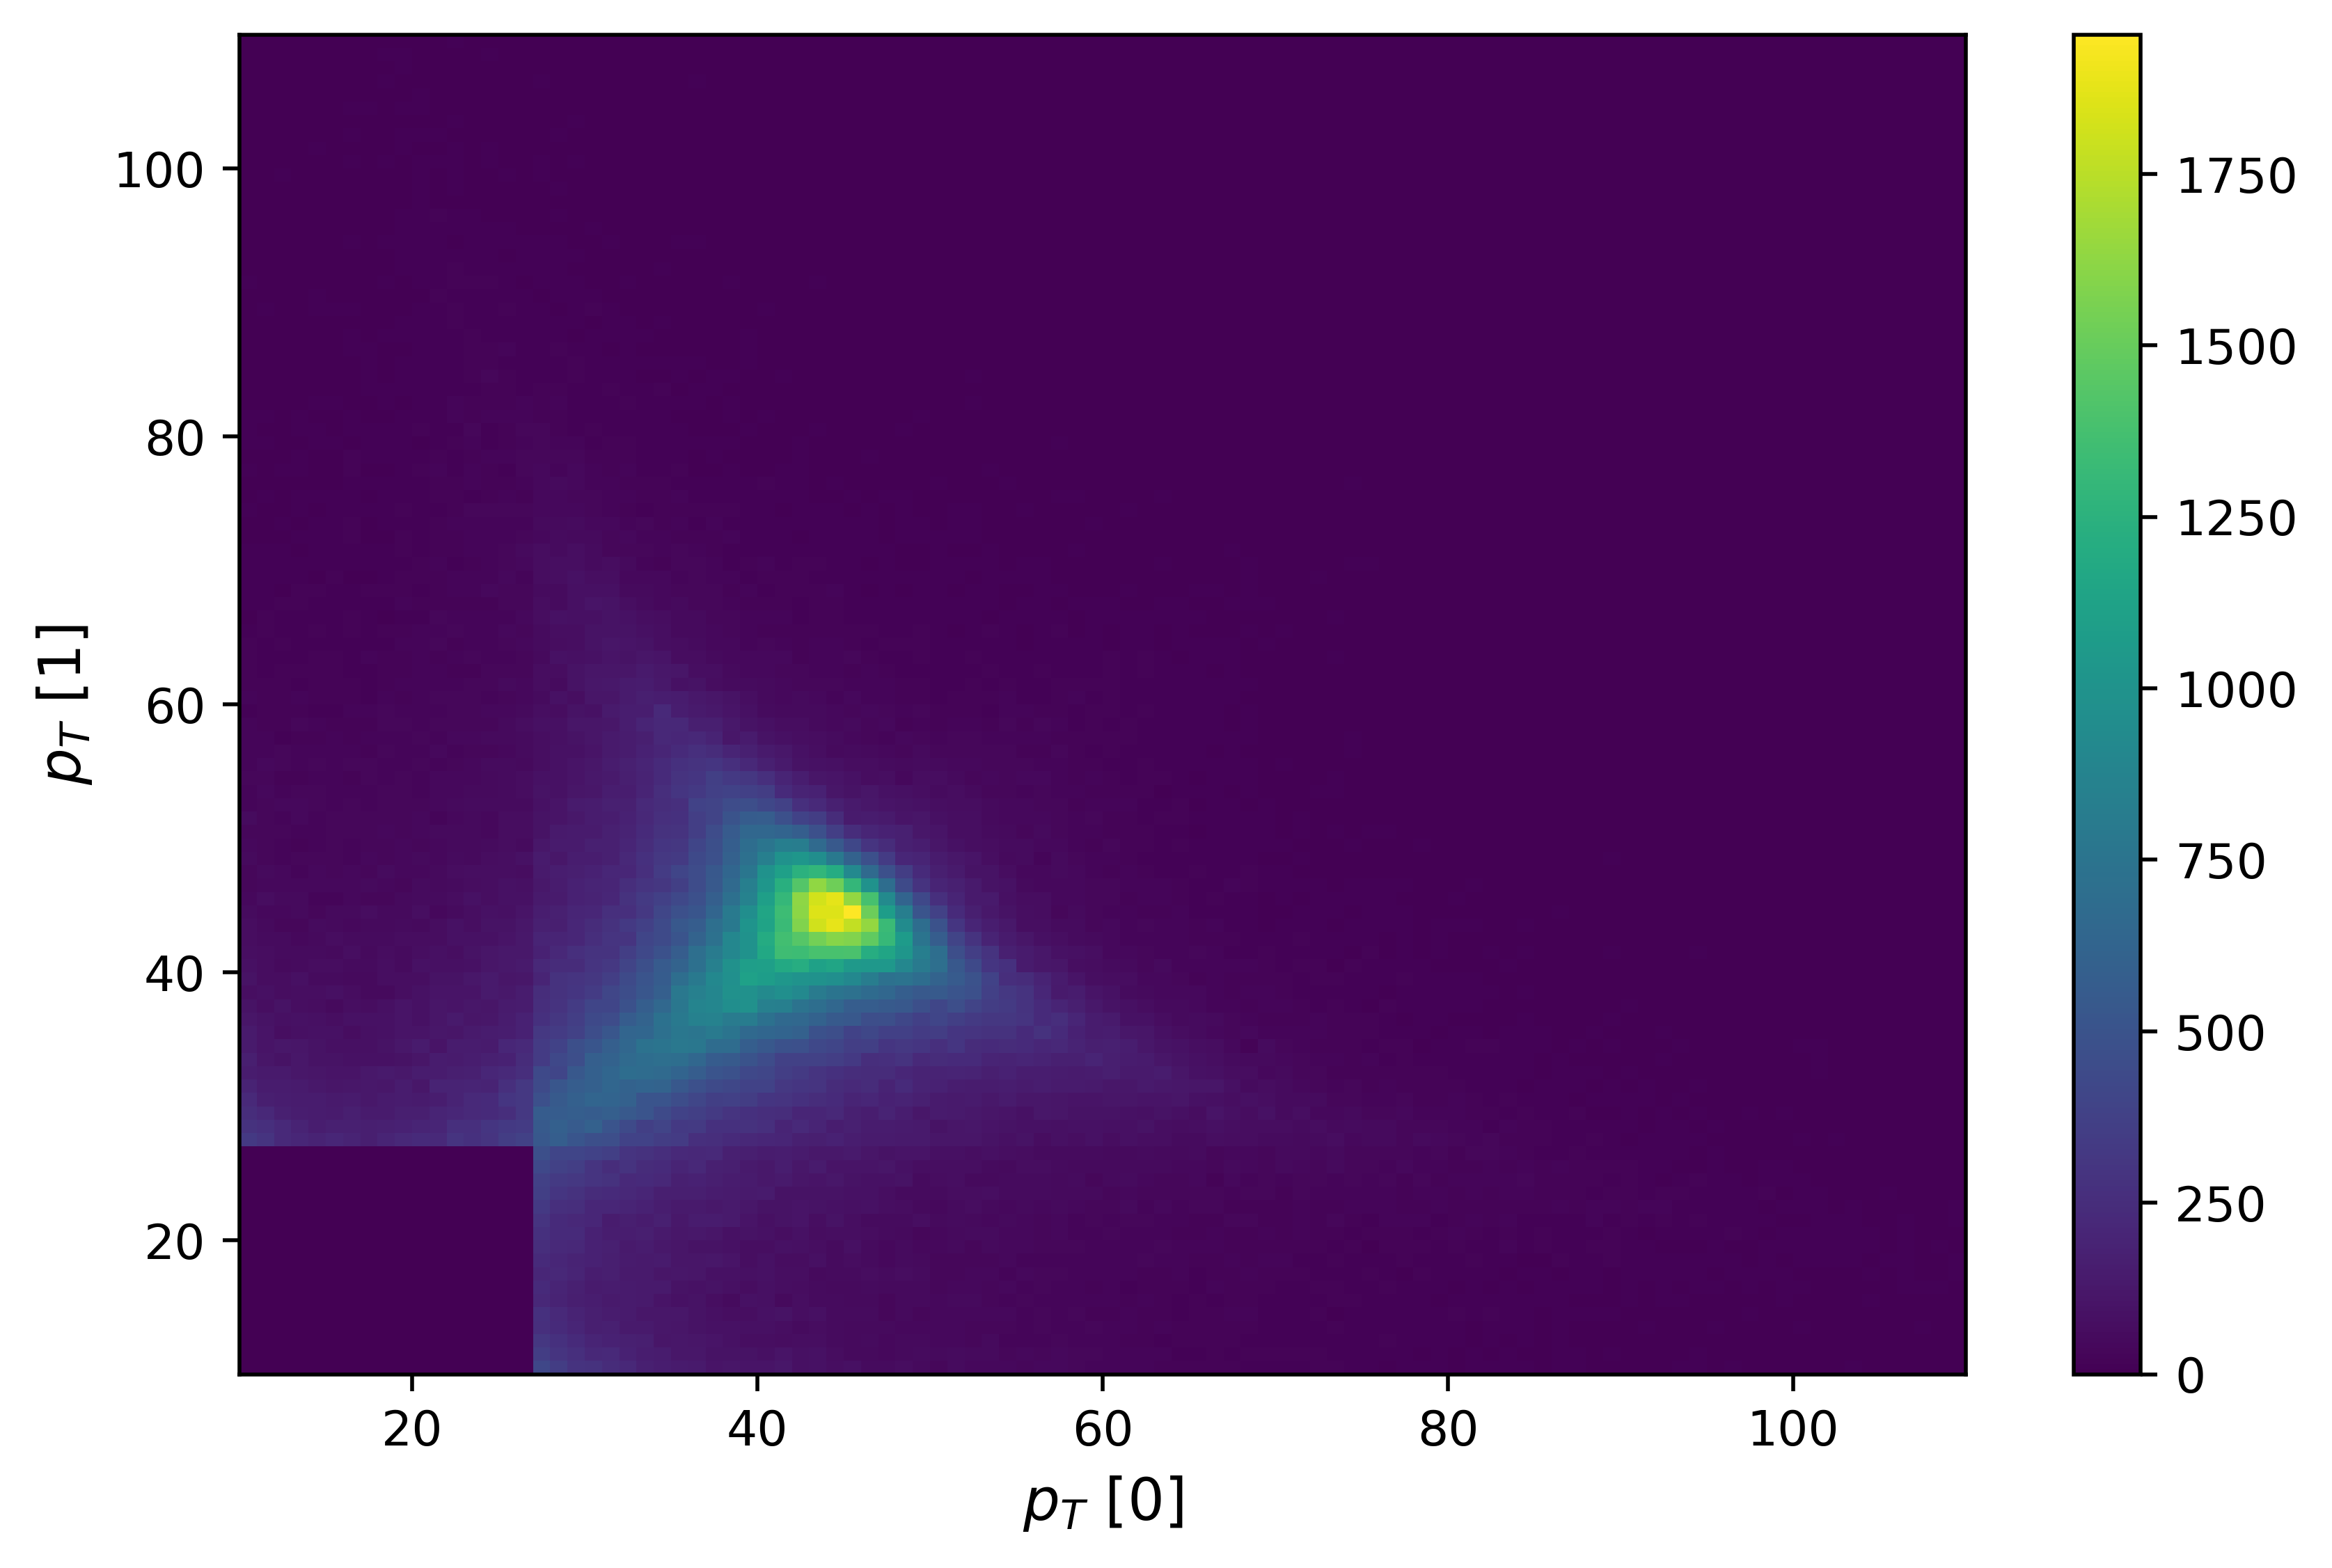

In [ ]:

data_pt0 = pt_data['2to4lep_0_02']['lep_pt'][:, 0]
data_pt1 = pt_data['2to4lep_0_02']['lep_pt'][:, 1]
data_2d = (data_pt0, data_pt1) # Plot lep_pt[0] on x-axis, lep_pt[1] on y-axis
num_bins_2d = (100, 100) # Number of bins along x and y-axis 
min_max_2d = ((10, 110), (10, 110)) # The bin range in x and y
label_2d = ('$p_T$ [0]', '$p_T$ [1]') # The labels for x and y-axis


# Plot the 2D histogram
fig, h = histogram_2d(data_2d, num_bins_2d,
                      min_max_2d, label_2d,
                      # Optional arguments
                      # label_fontsize=12, tick_labelsize=10,
                      # title_fontsize=13, title='',
                      # colorbar_label='Events'
                    )
# Uncomment to save the image
#fig.savefig('test.png', dpi=500)

## Write the Data to Disk
When working with larger datasets, e.g. using a higher `fraction` in `analysis_parquet`, it is often more efficient to write the data to disk rather than keeping it all in memory. 

To do this, set the optional argument `write_parquet=True`. This will instruct the `analysis_parquet` function to save the output as Parquet files. If you write data to disk, it is recommended to set `return_output=False` to avoid loading large amounts of data into memory.  

In addition, you can customise the output location using the `output_directory` argument. If not provided, the files will be saved in an `output` folder with a unique name created from the current date and time.  

**Note**: The provided output directory must be unique and cannot be reused. Attempting to write to an existing directory will raise a `FileExistsError` to prevent accidental overwriting of data.   

For example, the following makes a tighter preselection of di-lepton events.


In [ ]:
# Write your own di-lepton preselection to parquet files

string_code_list = ['2to4lep', 'Zmumu', 'm10_40_Zmumu', 'Ztautau', 'ttbar', 'Wmunu', 'Wtaunu'] # List of dataset codes to load
#string_code_list = ['2to4lep', 'Zee', 'm10_40_Zee', 'Ztautau', 'ttbar', 'Wenu', 'Wtaunu'] # List of dataset codes to load

# Specify the variables to be read in.
# These variables will also be written out, in addition to any defined in the function 'preselection_cut' below
read_variables = ['lep_n', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_e', 'lep_ptvarcone30', 'lep_topoetcone20', 'lep_type', 'lep_charge', 'trigE', 'trigM', 'lep_isTrigMatched',
                   'lep_isLooseID', 'lep_isMediumID', 'lep_isLooseIso', 'lep_isTightIso']

# Alternatively, you may wish to use the pre-defined function `validate_read_variables` to find the names of all available variables
#read_variables = get_valid_variables('2to4lep') # Save all available variables

# Specify the directory to which the output parquet files should be written
output_dir = '../../output-parquet/dimuon_massGT15_PtGT15'

# Custom selection cut function to filter the data when writing out parquet files
def preselection_cut(data):
    # Use bitwise operator '&' for AND, '|' for OR. Remember to put parentheses around each logical (sub)expression!

    # Cut on lepton number - Only keep events that have two leptons
    data = data[data['lep_n'] == 2] 

    # Cut on lep_type
    # lep_type is 11 for electron, 13 for muon
    #data = data[data['lep_type'][:, 0] + data['lep_type'][:, 1] == 22] # Keep events with two electrons
    data = data[data['lep_type'][:, 0] + data['lep_type'][:, 1] == 26] # Keep events with two muons

    # Require that a single electron trigger fired 
    #data = data[(data['trigE'])] 
    # Require that a single muon trigger fired 
    data = data[(data['trigM'])] 

    # Require at least one lepton to have  pt > 27 GeV and be trigger matched
    # N.B. not needed here because this has already been required in the pre-selection of the parquet files you are reaeding in
    #data = data[((data['lep_pt'][:, 0] > 27) & (data['lep_isTrigMatched'][:, 0])) | ((data['lep_pt'][:, 1] > 27) & (data['lep_isTrigMatched'][:, 1]))]

    # Find the pt of the lepton with the lowest pt of the two and add this variable to the data to be stored on the output parquet files
    data['soft_pt'] = ((data['lep_pt'][:, 0] > data['lep_pt'][:, 1])*data['lep_pt'][:, 1]) + ((data['lep_pt'][:, 0] < data['lep_pt'][:, 1])*data['lep_pt'][:, 0])

    # Cut on lepton pt - Keep events where both leptons have pt > 15 GeV
    # Use bitwise operator '&' for AND, '|' for OR. Remember the parentheses!
    LoosePt = 15
    data = data[(data['lep_pt'][:, 0] > LoosePt) & (data['lep_pt'][:, 1] > LoosePt)]

    # Define four momentum
    four_momentum = vector.zip({
        'pt': data['lep_pt'],
        'eta' : data['lep_eta'],
        'phi' : data['lep_phi'],
        'E' : data['lep_e']
    })
    # Add the 4-momentum of the two leptons in each event and get the invariant mass using .M
    data['mass'] = (four_momentum[:, 0] + four_momentum[:, 1]).M
    
    # Cut on di-lepton mass
    cut_low = 15
    cut_high = 1000   
    cut_mass = (data['mass']>cut_low) &  (data['mass']<cut_high)
    data = data[cut_mass] # Select events satisfying the condition: cut_low < mass < cut_high (GeV)
        
    # Tip: if you want to plot a variable that is a mathematical function of one or more of the input variables then do something like the following: 
    # Calculate the product of the charges of the two leptons.  
    data['charge_product'] = data['lep_charge'][:, 0] * data['lep_charge'][:, 1]

    # Select same-sign (['charge_product']>0), or opposite-sign (['charge_product']<0) events
    #data = data[data['charge_product']<0]
 
    return data

fraction = 0.02

# The argument "write_parquet=True" tells the function to write new parquet files to the output directory "output_dir"
# The argument "return_output=False" tells the function NOT to store data from the selected events to memory (Needed to avoid overflowing the memory limit for fraction = 1)
analysis_parquet(read_variables, string_code_list, fraction=fraction, cut_function=preselection_cut, write_parquet=True, output_directory=output_dir, return_output=False)

# In order to make plots from these new parquet files you need to read them back in using the next cell


Write data to output_directory: ../../output-parquet/dimuon_massGT15_PtGT15
Input string_code_list found. Data samples will be accessed by the string code(s).
Elapsed time = 4.6s


Files saved by `analysis_parquet` can be reloaded using the same function by specifying the following optional arguments:
- `read_directory` : Path to the directory where the data is saved.
- `subdirectory_names` : A list of subdirectories (folder names) to read from. If not provided, all subdirectories in `read_directory` will be read.
  
Note that `string_code_list` is also an optional argument with a default of `None`. Either `string_code_list` _**or**_ `read_directory` must be provided to the `analysis_parquet` function.  

**_Tip_**: Before loading large datasets, it is recommended to restart the kernel to free up memory. Avoid reading too many variables at once to reduce memory usage.

In [ ]:
# Read in your private di-lepton analysis parquet files and store the required data in memory

read_directory = '../../output-parquet/dimuon_massGT15_PtGT15' # Directory where data was saved when running the previous cell
# N.B. the '../../' in the directory name means that the output directory is created in your "home" directory rather then getting mixed up with your code
get_valid_variables('2to4lep')

# Specify which variables you want to read in for each event
read_variables = ['mass', 'charge_product']
#read_variables = ['lep_n', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_e', 'lep_ptvarcone30', 'lep_topoetcone20', 'lep_type', 'lep_charge', 'trigE', 'trigM', 'lep_isTrigMatched',
#                   'lep_isLooseID', 'lep_isMediumID', 'lep_isLooseIso', 'lep_isTightIso', 'soft_pt', 'charge_product']

fraction = 1

# Custom selection cut function to filter the data
def read_parquet_cut(data):

    # Cut on lep_type
    # lep_type is 11 for electron, 13 for muon
    #data = data[data['lep_type'][:, 0] + data['lep_type'][:, 1] == 26]

    # Cut on di-lepton mass
    cut_low = 85
    cut_high = 95   
    cut_mass = (data['mass']>cut_low) &  (data['mass']<cut_high)
    data = data[cut_mass] # Select events satisfying the condition: cut_low < mass < cut_high (GeV)

    # Select same-sign (['charge_product']>0), or opposite-sign (['charge_product']<0) events
    data = data[data['charge_product']<0]
 
    
    return data
    
pt_data = analysis_parquet(read_variables, string_code_list=None, read_directory=read_directory,
                        subdirectory_names=None, fraction=fraction, cut_function=read_parquet_cut,
                        write_parquet=False, output_directory=None, return_output=True)
pt_data

# You can now in principle use all of the various plotting functions in the cells above on the data you have now stored in memory.
# N.B. In the plotting functions you will need to change the names of the items in "plot_dict" to correspond to the keys written out below

Variables validated using ../../parquet/2to4lep/chunk_0.parquet
Input read_directory found. Data will be read from ../../output-parquet/dimuon_massGT15_PtGT15.
No data found for ['mass' 'charge_product' 'totalWeight'] in ../../output-parquet/dimuon_massGT15_PtGT15/m10_40_Zmumu_0_02/chunk0.parquet after selection cut
Elapsed time = 0.1s


{'Zmumu_0_02 x1': <Array [{totalWeight: 0.106, ...}, ..., {...}] type='601439 * {totalWeight:...'>,
 'ttbar_0_02 x1': <Array [{totalWeight: 0.318, ...}, ..., {...}] type='524 * {totalWeight: fl...'>,
 'Wmunu_0_02 x1': <Array [{totalWeight: -0.148, ...}, ..., {...}] type='35 * {totalWeight: fl...'>,
 '2to4lep_0_02 x1': <Array [{totalWeight: 1, mass: 88, ...}, ...] type='383429 * {totalWeight: ...'>,
 'Wtaunu_0_02 x1': <Array [{totalWeight: 0.268, ...}, {...}] type='2 * {totalWeight: float64, ...'>,
 'm10_40_Zmumu_0_02 x1': None,
 'Ztautau_0_02 x1': <Array [{totalWeight: 0.373, ...}, ..., {...}] type='24 * {totalWeight: flo...'>}

Note the *change* in the keys of the output dictionary. Each key is constructed by combining the subdirectory name with the `fraction`, separated with`' x'`.  
For example, if the subdirectory name is `'Zee_0_01'` and `fraction = 0.1`, the resulting key will be `'Zee_0_01 x0_1'`, implying that the sample represents `0.01 × 0.1` of the original dataset.  
However, this naming convention does not reflect whether any cuts have been applied, hence the actual number of events is likely not this fraction of the full data —  it only provides a rough estimate. So, make sure to **record** your output directories and cuts clearly in your lab book!

In [ ]:
  
# Function 'produced_event_count' returns the total number (sum of weights) of generated Monte Carlo events for the data set specified by 'dataKey' and the specificed integrated luminosity.
# You will need this as the denominator in the calculation of the selection efficiency for your signal processes
luminosity = 36.6
produced_event_count('Zmumu',luminosity)

The total number of produced events (sum of weights) for Monte Carlo data set Zmumu and luminosity 36.6 inverse femtobarns is 81299580


81299580.00000001